### Add Path of source code file

In [1]:
import sys
import os
from pathlib import Path

def add_top_directory_to_python_path(top_directory : str = "Project"):
    """
    Add top directory of Project to Python Path for managing import between directory

    Args:
        top_directory (str, optional): top folder of project. Defaults to "Project".
    """
    current_dir_path = Path(os.getcwd())
    current_dir_name = current_dir_path.stem
    
    while (current_dir_name != top_directory):
        current_dir_path = current_dir_path.parent
        current_dir_name = current_dir_path.stem
    
    sys.path.append(str(current_dir_path))
    print(f"[INFO] : add [{current_dir_path}] to Python path")

add_top_directory_to_python_path(top_directory="Project")

[INFO] : add [/home/widium/Programming/AI/Vision-Transformer/Project] to Python path


### Load Dataloader

In [2]:
import torch
from pathlib import Path

SAVING_PATH = Path("data/dataset/")

train_dataset_path = SAVING_PATH / "train_dataset.pth"
test_dataset_path = SAVING_PATH / "test_dataset.pth"

train_dataloader = torch.load(f=train_dataset_path)
test_dataloader = torch.load(f=test_dataset_path)

len(train_dataloader), len(test_dataloader)

(8, 3)

### Create the ViT Base Instance
![](https://i.imgur.com/GLaAgax.png)

- Define the Hyperparameters Constante for recreate the ViTBase 

In [3]:
NBR_CLASS = 3
HEIGHT = 224
WIDTH = 224
COLOR = 3
PATCH_SIZE = 16
EMBEDDING = 768
NBR_ENCODER_BLOCK = 12
NBR_HEADS = 12
MLP_UNITS = 3072

In [4]:
from modeling.builder.vit_model import VisionTransformerClassifier

vit_base = VisionTransformerClassifier(
    nbr_classes=NBR_CLASS,
    height=HEIGHT,
    width=WIDTH,
    color_channels=COLOR,
    patch_size=PATCH_SIZE,
    embedding_size=EMBEDDING,
    nbr_encoder_blocks=NBR_ENCODER_BLOCK,
    nbr_heads=NBR_HEADS ,
    mlp_units=MLP_UNITS,
    dropout_embedding=0.1,
    dropout_attention=0.0,
    dropout_mlp=0.1,
)

In [5]:
from torchinfo import summary

summary(model=vit_base, 
        input_size=(1, COLOR, HEIGHT, WIDTH),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                                Input Shape          Output Shape         Param #              Trainable
VisionTransformerClassifier (VisionTransformerClassifier)              [1, 3, 224, 224]     [1, 3]               --                   True
├─ImageTokenizer (image_tokenizer)                                     [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─PatchExtractor (patch_extractor)                                [1, 3, 224, 224]     [1, 3, 14, 14]       --                   True
│    │    └─Conv2d (patch_extractor)                                   [1, 3, 224, 224]     [1, 3, 14, 14]       2,307                True
│    └─PatchTokenizer (patch_tokenizer)                                [1, 3, 14, 14]       [1, 196, 3]          --                   --
│    │    └─Flatten (flatten)                                          [1, 3, 14, 14]       [1, 3, 196]          --                   --
│    └─PatchTokenEmbedding

### Create Loss Function, Optimizer and Metrics for Training Loop

- Setup the optimizer with the same configuration as in the paper
with $β1$ = 0.9, $β2$ = 0.999 and weight decay = 0.1

In [7]:
from torch.optim import Adam

optimizer = Adam(
    params=vit_base.parameters(),
    lr=0.001, # 10e-3
    betas=(0.9, 0.999),
    weight_decay=0.1,
)

- Loss Function and Metric Function

In [8]:
from torch.nn import CrossEntropyLoss
from torchmetrics import Accuracy

loss_function = CrossEntropyLoss()
metric_function = Accuracy(task="multiclass", num_classes=NBR_CLASS)

### Use the `train` Function 
- setup device 

In [9]:
### Setup device agnostic code
device = "cpu"

vit_base.to(device)
print(f"Using device: {device}")

Using device: cpu


  0%|          | 0/5 [00:00<?, ?it/s]

Epochs            | Train Loss        | Train Accuracy    | Val Loss          | Val Accuracy      |
20.0% [1/5]       | 3.1534            | 0.4492            | 3.0382            | 0.1979            |
-----------------------------------------------------------------------------------------------
40.0% [2/5]       | 1.6586            | 0.2344            | 1.2976            | 0.1979            |
-----------------------------------------------------------------------------------------------
60.0% [3/5]       | 1.4409            | 0.4180            | 2.0727            | 0.1979            |
-----------------------------------------------------------------------------------------------
80.0% [4/5]       | 1.3836            | 0.2852            | 1.1639            | 0.2604            |
-----------------------------------------------------------------------------------------------
100.0% [5/5]      | 1.2031            | 0.2695            | 1.0404            | 0.5417            |
----------------

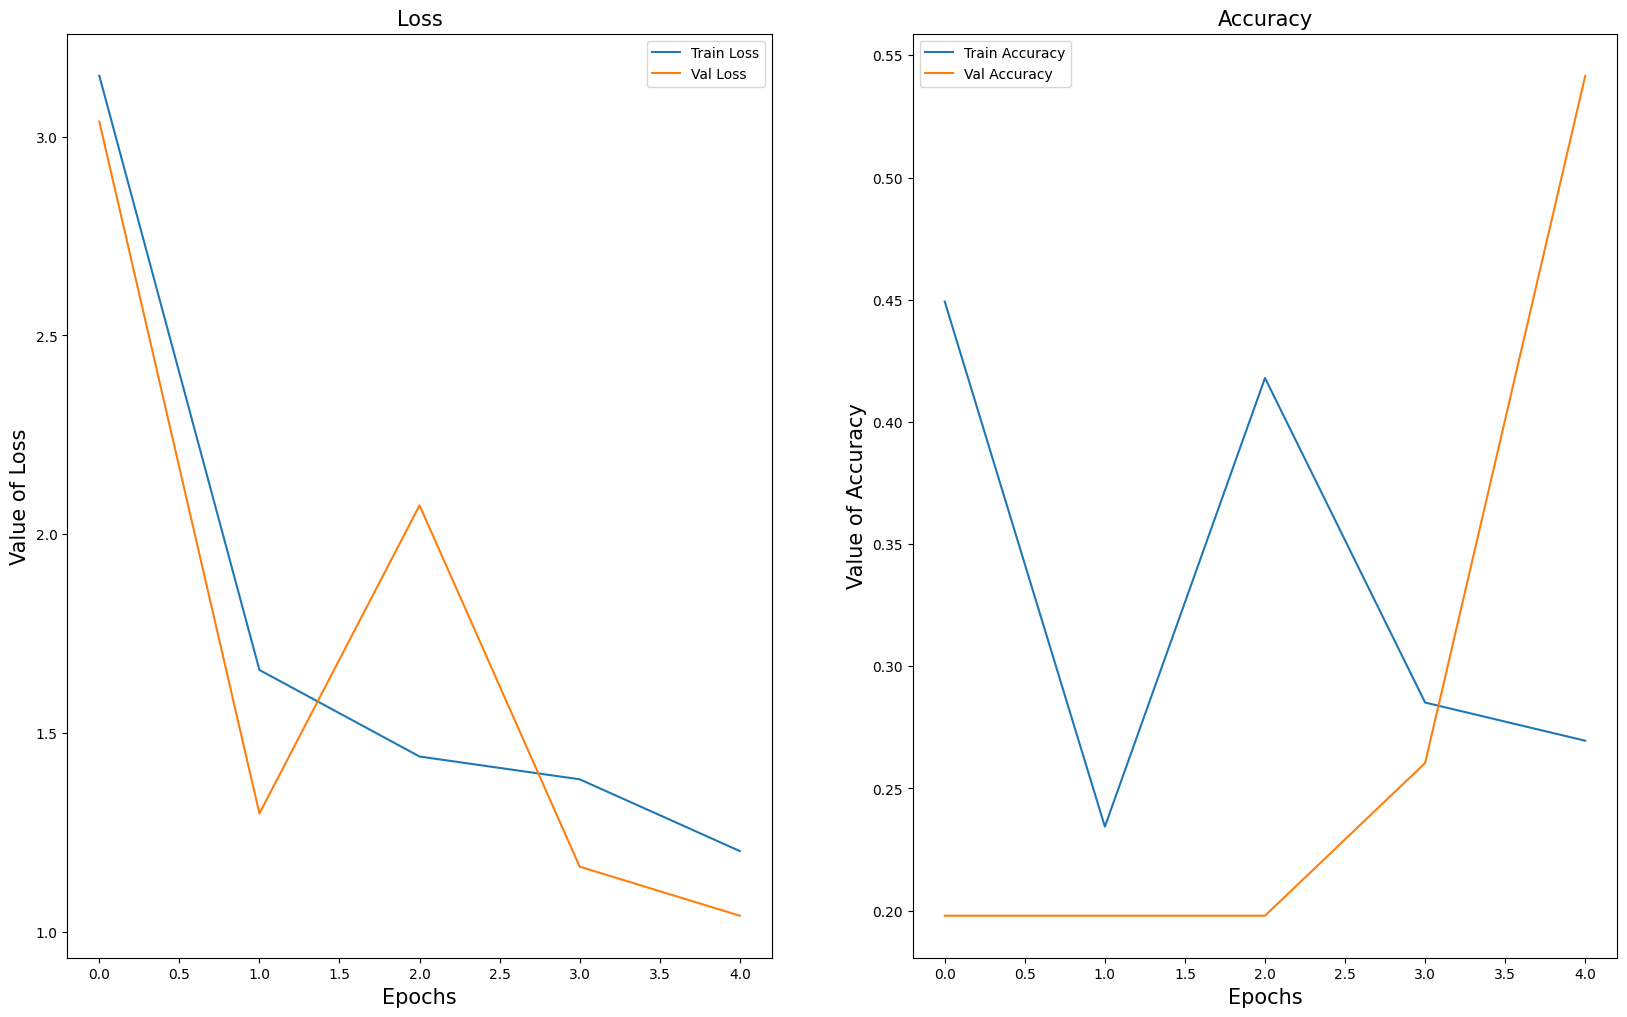

In [10]:
from modeling.training.train import train

history = train(
    model=vit_base,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    metric_function=metric_function,
    device=device,
    epochs=5
)

In [13]:
history.diagnostic_results

{'Bias and UnderFitting': ['High Bias', 'UnderFitting'],
 'Variance and OverFitting': ['Low Variance', 'Good Generalization !'],
 'Last Train Accuracy': '0.270',
 'Last Val Accuracy': '0.542'}

unfortunately the model perform very badly for the following reasons :
- Very small dataset 8 batch of 32 sample (225 sample)
- Lot of Parameters to train with this configuration (85,215,750 parameters)...
- Small computing power, i train this model on my laptop with 32 gb CPU because my GPU have 4 gb...
***
I create all this for learning purpose !